# Coordinate systems and transforms of Synthesis AI dataset

First, we install `synthesisai` and download test datasets.

In [ ]:
%%bash
python -m pip install synthesisai
curl https://synthesisai-example-datasets.s3.amazonaws.com/humans_api_example_dataset.zip -o humans_api_example_dataset.zip
unzip humans_api_example_dataset.zip -d humans_api_example_dataset

Finally we add some imports for the visualisation.

In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np

We use `SaiDataset` class to access synthesis datasets.


In [3]:
from synthesisai import SaiDataset, Modality

In [4]:
data_root = "humans_api_example_dataset"
dataset = SaiDataset(
    data_root,
    modalities=[
        Modality.RGB, Modality.CAM_TO_HEAD, Modality.HEAD_TO_CAM,
        Modality.WORLD_TO_HEAD, Modality.HEAD_TO_WORLD, Modality.WORLD_TO_CAM,
        Modality.CAM_TO_WORLD, Modality.LANDMARKS_3D_IBUG68
    ]
)

In [5]:
len(dataset)

129

There are 129 items in the test dataset. Let's explore them closer.

In [7]:
item = dataset[0]
item2 = dataset[1]

Each item is a dict with different modalities as keys.

In [8]:
print(item.keys())

dict_keys([<Modality.RGB: 2>, <Modality.LANDMARKS_3D_IBUG68: 15>, <Modality.HEAD_TO_CAM: 29>, <Modality.CAM_TO_HEAD: 30>, <Modality.HEAD_TO_WORLD: 31>, <Modality.WORLD_TO_HEAD: 32>, <Modality.CAM_TO_WORLD: 33>, <Modality.WORLD_TO_CAM: 34>])


In the Synthesis AI dataset we use 3 different coordinate systems:
1.  World coordinate system.
2.  Camera coordinate system, centered at the camera with x-axis directed right, y-axis directed top and z-axis directed towards the camera.
3.  Head coordinate system, centered at the center of the face with x-axis directed toward the left ear, y-axis directed to the top of the head and z-axis directed towards the nose.

We provide transformations between head, camera and world coordinates systems as 4x4 matrices in homogeneous coordinates.

In [9]:
item[Modality.CAM_TO_HEAD]

{'human_1': array([[ 9.99998535e-01,  6.03345439e-08,  3.14740086e-07,
          2.75436319e-07],
        [ 8.38196454e-09,  9.99998383e-01, -3.43226609e-06,
         -3.51552562e-06],
        [-3.36250585e-08,  3.27302335e-06,  9.99998193e-01,
          9.99998030e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])}

In [10]:
item[Modality.HEAD_TO_CAM]

{'human_1': array([[ 1.00000147e+00, -6.03336997e-08, -3.14741323e-07,
          3.93037687e-08],
        [-8.38187496e-09,  1.00000162e+00,  3.43227784e-06,
          8.32602263e-08],
        [ 3.36251959e-08, -3.27303456e-06,  1.00000181e+00,
         -9.99999838e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])}

In [11]:
item[Modality.HEAD_TO_WORLD]

{'human_1': array([[ 0.98877245, -0.0887183 ,  0.12025385, -0.01294463],
        [ 0.14895648,  0.64971954, -0.74543935,  1.58168411],
        [-0.01199738,  0.75498134,  0.65563923,  0.1424308 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])}

In [12]:
item[Modality.WORLD_TO_HEAD]

{'human_1': array([[ 0.98876958,  0.14895588, -0.01199711, -0.22109313],
        [-0.08871796,  0.64971756,  0.75497879, -1.1363286 ],
        [ 0.1202537 , -0.74543672,  0.65563674,  1.08721919],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])}

In [13]:
item[Modality.CAM_TO_WORLD]

array([[ 0.988771  , -0.0887177 ,  0.12025424,  0.10730956],
       [ 0.14895629,  0.64971605, -0.74544019,  0.83624399],
       [-0.01199738,  0.75498226,  0.65563545,  0.79806608],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [14]:
item[Modality.WORLD_TO_CAM]

array([[ 0.988771  ,  0.14895629, -0.01199738, -0.22109369],
       [-0.0887177 ,  0.64971605,  0.75498226, -1.13632662],
       [ 0.12025424, -0.74544019,  0.65563545,  0.08722503],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

X_TO_Y transform is always inverse of Y_TO_X:

In [15]:
human_instance_ids = item[Modality.CAM_TO_HEAD].keys()
# each human has its own cam-to-head and head-to-cam transform
for human_instance_id in human_instance_ids:
    np.testing.assert_allclose(item[Modality.CAM_TO_HEAD][human_instance_id] @ item[Modality.HEAD_TO_CAM][human_instance_id], np.eye(4), atol=1e-10)
    np.testing.assert_allclose(item[Modality.HEAD_TO_WORLD][human_instance_id] @ item[Modality.WORLD_TO_HEAD][human_instance_id], np.eye(4), atol=1e-10)
np.testing.assert_allclose(item[Modality.CAM_TO_WORLD] @ item[Modality.WORLD_TO_CAM], np.eye(4), atol=1e-10)

And composition of X_TO_Y and Z_TO_X transforms always give Z_TO_Y transform:

In [16]:
for human_instance_id in human_instance_ids:
    np.testing.assert_allclose(item[Modality.CAM_TO_WORLD], item[Modality.HEAD_TO_WORLD][human_instance_id] @ item[Modality.CAM_TO_HEAD][human_instance_id], atol=1e-10)

All 3D coordinates (ex. landmarks) are always given in camera coordinates.

In [17]:
item[Modality.LANDMARKS_3D_IBUG68][human_instance_id][0]

(-0.0748477652668953, -0.002214750275015831, -1.0413579940795898)

If we want to get coordinates in the head coordinate system (they should be independent on camera position and pitch/yaw/roll values),
we need to multiply them by CAM_TO_HEAD transform.

However, as matrices are in homogeneous coordinates, first we will need to transform them to homogeneous coordinates:

In [18]:
def to_homogeneous(xs):
    xs_array = np.array(xs)
    assert (xs_array.shape[-1] == 3)
    ones_shape = list(xs_array.shape)
    ones_shape[-1] = 1
    homogeneous = np.concatenate([xs_array, np.ones(ones_shape)], axis=-1)
    return homogeneous

In [19]:
homogeneous_cam = to_homogeneous(item[Modality.LANDMARKS_3D_IBUG68][human_instance_id][0])
homogeneous_cam

array([-0.07484777, -0.00221475, -1.04135799,  1.        ])

We wrote our own function instead of using opecv one, so it can work with multidimensional arrays of points.
Opencv function can work only with 1-d arrays of points, neither single point, nor multidimensional arrays are supported.
In this particular case, opencv function will suffice:

In [20]:
cv2.convertPointsToHomogeneous(np.array([item[Modality.LANDMARKS_3D_IBUG68][human_instance_id][0]]))[0]

array([[-0.07484777, -0.00221475, -1.04135799,  1.        ]])

Now, we can compute homogeneous coordinates in head coordinate system.

In [21]:
homogeneous_head = item[Modality.CAM_TO_HEAD][human_instance_id] @ homogeneous_cam
homogeneous_head

array([-0.07484771, -0.00221469, -0.04135809,  1.        ])

Now, we need to transform back to euclidian coordinates:

In [22]:
def from_homogeneous(xs):
    xs_array = np.array(xs)
    assert (xs_array.shape[-1] == 4)

    slice_but_last = list(xs_array.shape)
    slice_but_last[-1] = slice(None, -1)
    slice_but_last = tuple(slice_but_last)

    slice_last = list(xs_array.shape)
    slice_last[-1] = slice(-1, None)
    slice_last = tuple(slice_last)

    return xs_array[slice_but_last] / xs_array[slice_last]

And we can compute euclidian coordinates in the head space as:

In [23]:
from_homogeneous(homogeneous_head)

array([-0.07484771, -0.00221469, -0.04135809])

Once again, we can use opencv convertion function:

In [24]:
cv2.convertPointsFromHomogeneous(np.array([homogeneous_head]))[0]

array([[-0.07484771, -0.00221469, -0.04135809]])

We can use these transforms to estimate pitch/yaw/roll values (rotation of the head, relative to the world).

In [25]:
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt


In [26]:
def get_yaw_pitch_roll_world(item, human_instance_id):
    rotation = R.from_matrix(item[Modality.WORLD_TO_HEAD][human_instance_id][:3,:3])

    # We multiply resulting angles by [-1, 1, -1] to use the same positive axis
    # as in job generaton json.
    yaw, pitch, roll = rotation.as_euler("YXZ", degrees=True) * [-1, 1,-1]
    return yaw, pitch, roll

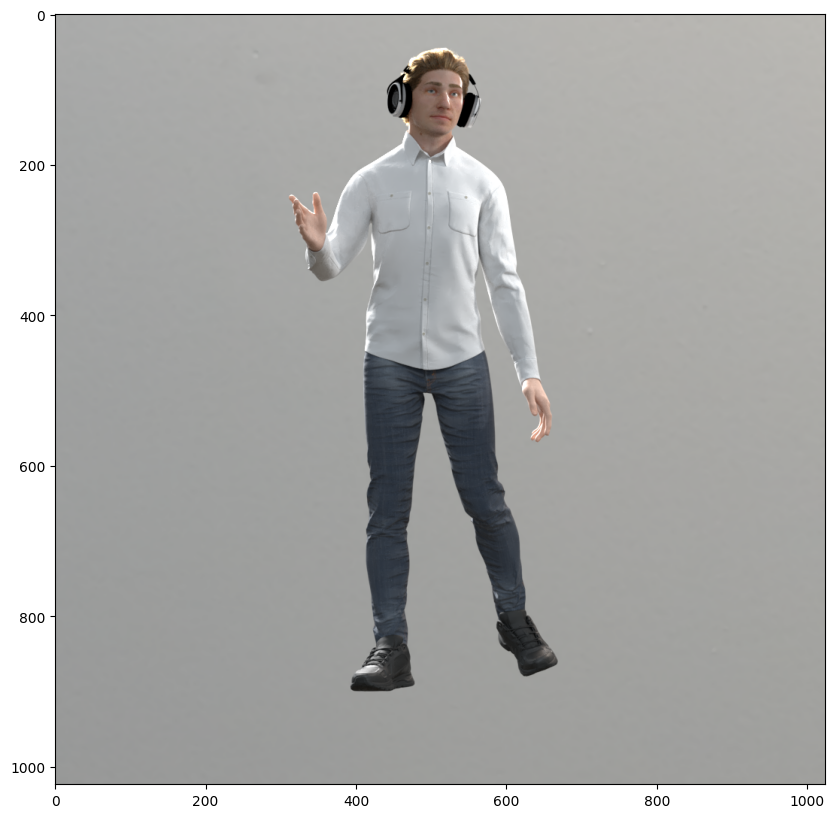

In [27]:
item = dataset[54]
plt.figure(figsize=(10,10))
plt.imshow(item[Modality.RGB])

In [28]:
get_yaw_pitch_roll_world(item, human_instance_id)

(17.054323051041937, -2.2672862051975105, -6.610598523407923)

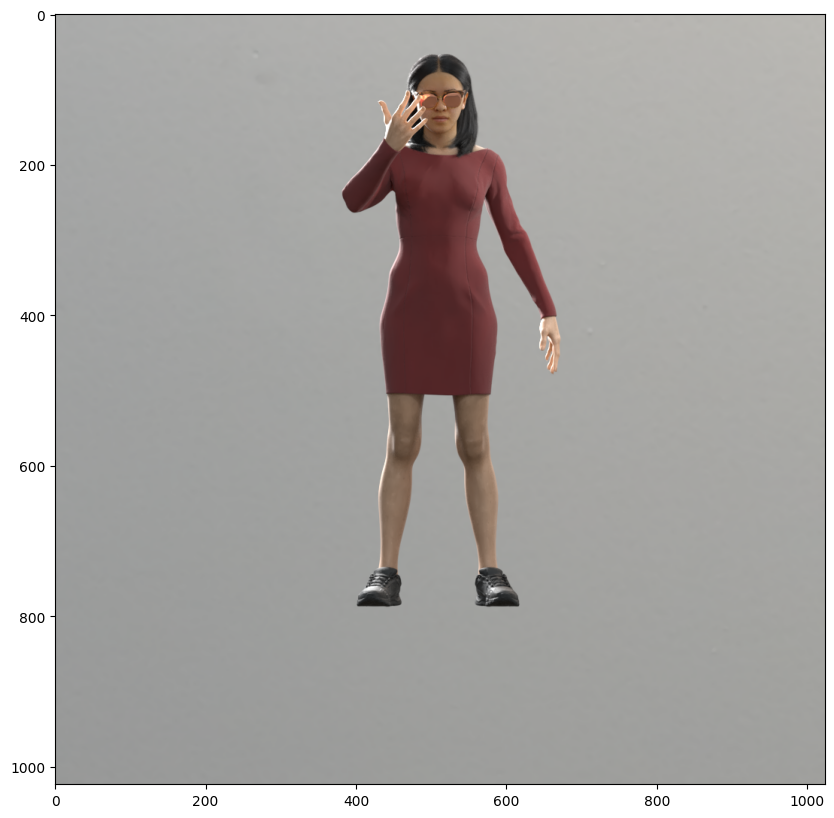

In [29]:
item = dataset[56]
plt.figure(figsize=(10,10))
plt.imshow(item[Modality.RGB])

In [30]:
get_yaw_pitch_roll_world(item, human_instance_id)


(-0.21204820762753307, -17.367764358234933, 2.131151376166399)